In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
file_path = '/content/drive/My Drive/prosperLoanData.csv'
import pandas as pd
df = pd.read_csv(file_path)

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')


# Filtered columns after PCA multicollinearity test
filtered_columns = [
    'Term', 'LoanStatus', 'BorrowerAPR', 'EstimatedReturn',
    'ProsperRating (numeric)', 'ListingCategory (numeric)',
    'BorrowerState', 'Occupation', 'EmploymentStatus',
    'IsBorrowerHomeowner', 'CreditScoreRangeLower',
    'OpenCreditLines', 'TotalCreditLinespast7years',
    'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
    'InquiriesLast6Months', 'CurrentDelinquencies',
    'AmountDelinquent', 'PublicRecordsLast10Years',
    'RevolvingCreditBalance', 'BankcardUtilization',
    'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
    'StatedMonthlyIncome', 'LoanOriginalAmount',
    'MonthlyLoanPayment'
]
sliced_data = df[filtered_columns]

In [25]:
# Handling missing and negative values
# Numerical columns
numerical_cols = sliced_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    sliced_data[col].fillna(sliced_data[col].mean(), inplace=True)

# Categorical columns
categorical_cols = sliced_data.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    sliced_data[col].fillna(sliced_data[col].mode()[0], inplace=True)

# Convert negative values to zero
sliced_data[numerical_cols] = sliced_data[numerical_cols].applymap(lambda x: max(x, 0))

# Mapping LoanStatus to RiskCategory
def map_loan_status(status):
    if status in ['Current', 'Completed']:
        return 'Low Risk'
    elif status in ['FinalPaymentInProgress', 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 'Past Due (61-90 days)', 'Past Due (91-120 days)']:
        return 'Medium Risk'
    elif status in ['Chargedoff', 'Defaulted', 'Past Due (>120 days)', 'Cancelled']:
        return 'High Risk'

sliced_data['RiskCategory'] = sliced_data['LoanStatus'].apply(map_loan_status)

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    sliced_data[col] = le.fit_transform(sliced_data[col])

# Prepare the features (X) and target (y)
X = sliced_data.drop('RiskCategory', axis=1)
y = sliced_data['RiskCategory']

# Encode target variable
y_encoded = le.fit_transform(y)

# Initializing the RandomForest model 
adasyn = ADASYN(random_state=42)
rf_model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', adasyn),
    ('classifier', RandomForestClassifier(
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ))
])

# Defining the KFold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# An array to store the risk scores
personalized_risk_scores = np.zeros((len(sliced_data), 3))  # 3 classes

# KFold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    rf_model.fit(X_train, y_train)
    y_prob = rf_model.predict_proba(X_test)
    personalized_risk_scores[test_index] = y_prob

# Appending the personalized risk scores to the dataframe
sliced_data['PRS_HighRisk'] = personalized_risk_scores[:, 0]
sliced_data['PRS_LowRisk'] = personalized_risk_scores[:, 1]
sliced_data['PRS_MediumRisk'] = personalized_risk_scores[:, 2]

# Define a function to map RiskCategory to the corresponding PRS column
def get_prs(risk_category, high_risk_prs, low_risk_prs, medium_risk_prs):
    if risk_category == 'High Risk':
        return high_risk_prs
    elif risk_category == 'Low Risk':
        return low_risk_prs
    elif risk_category == 'Medium Risk':
        return medium_risk_prs
    else:
        return np.nan  # Return NaN if the risk category is not recognized

# Apply the function to create a new column 'PersonalizedRiskScore'
sliced_data['PersonalizedRiskScore'] = sliced_data.apply(
    lambda row: get_prs(
        row['RiskCategory'],
        row['PRS_HighRisk'],
        row['PRS_LowRisk'],
        row['PRS_MediumRisk']
    ),
    axis=1
)

# Drop the individual PRS columns
sliced_data.drop(columns=['PRS_HighRisk', 'PRS_LowRisk', 'PRS_MediumRisk'], inplace=True)



In [5]:
# Display the first few rows to verify
print(sliced_data[['RiskCategory', 'PersonalizedRiskScore']].head(20))

   RiskCategory  PersonalizedRiskScore
0      Low Risk               0.806526
1      Low Risk               0.995437
2      Low Risk               0.666084
3      Low Risk               0.936398
4      Low Risk               0.992372
5      Low Risk               0.994701
6      Low Risk               0.981152
7      Low Risk               0.942586
8      Low Risk               0.990931
9      Low Risk               0.987081
10     Low Risk               0.905075
11     Low Risk               0.958119
12  Medium Risk               0.970172
13     Low Risk               0.992059
14     Low Risk               0.979541
15    High Risk               0.614959
16     Low Risk               0.902329
17    High Risk               0.948808
18     Low Risk               0.986179
19     Low Risk               0.988040


In [6]:
from sklearn.metrics import classification_report

# Predict on the entire dataset to get a full classification report
y_pred = rf_model.predict(X)
y_true = y_encoded

# Print the classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00     17031
    Low Risk       1.00      1.00      1.00     94650
 Medium Risk       1.00      1.00      1.00      2256

    accuracy                           1.00    113937
   macro avg       1.00      1.00      1.00    113937
weighted avg       1.00      1.00      1.00    113937



In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

# Define the scorer for cross-validation
scorer = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y_encoded, cv=5, scoring=scorer)

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores)}')

# Define the scorer for ROC-AUC
roc_scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

# Perform cross-validation for ROC-AUC
cv_roc_scores = cross_val_score(rf_model, X, y_encoded, cv=5, scoring=roc_scorer)

print(f'Cross-Validation ROC-AUC Scores: {cv_roc_scores}')
print(f'Average Cross-Validation ROC-AUC: {np.mean(cv_roc_scores)}')


Cross-Validation Accuracy Scores: [0.99951729 0.99921011 0.99846404 0.99925396 0.99934173]
Average Cross-Validation Accuracy: 0.9991574254847027
Cross-Validation ROC-AUC Scores: [1.         0.99999996 0.99999958 0.99999996 1.        ]
Average Cross-Validation ROC-AUC: 0.9999998986720741


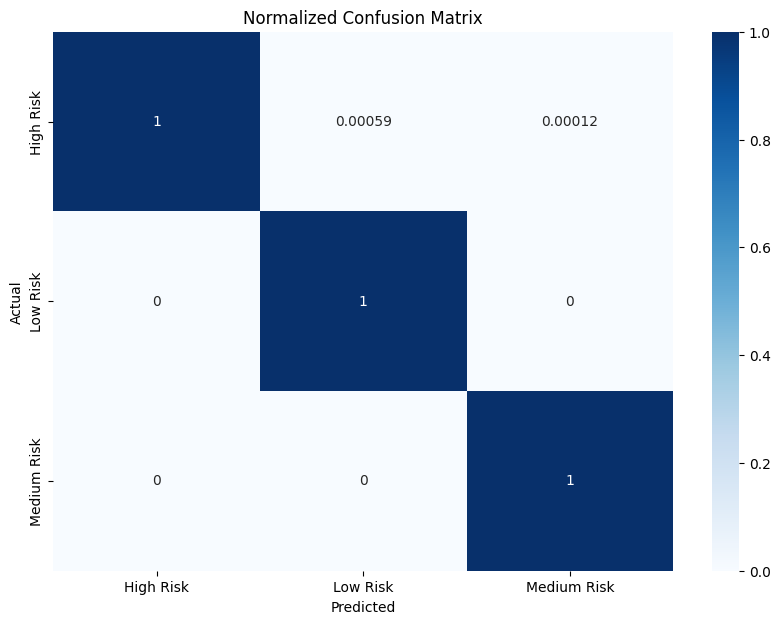

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_norm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


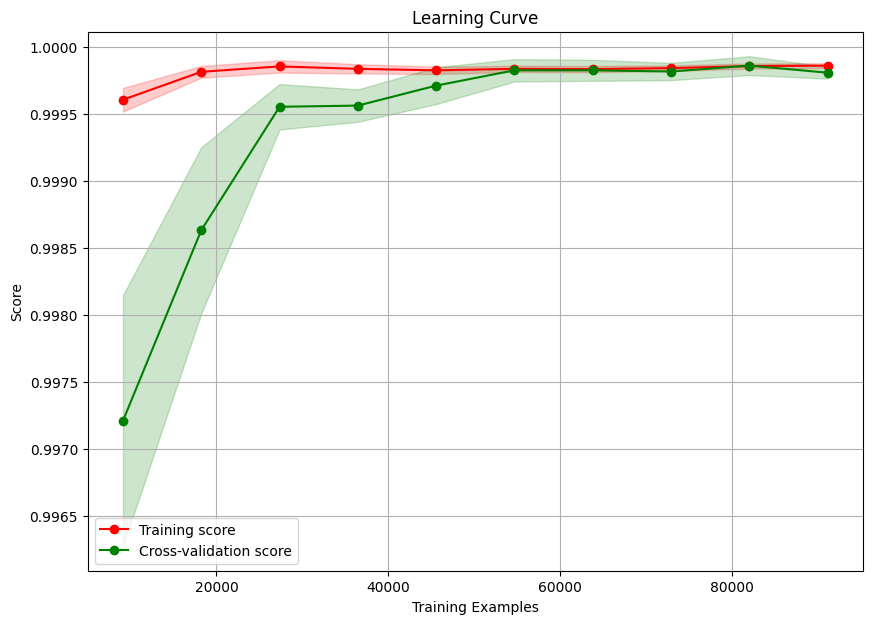

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define the model
rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5
)

# Define the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y_encoded, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate the mean and standard deviation of training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Plot the standard deviation as shaded areas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='g')

plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()
